In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from numpy import expand_dims

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
def plot_predictions(test, predicted):
    plt.plot(test, color='red', label='Real Turkish Lira Price')
    plt.plot(predicted, color='blue', label='Predicted Turkish Lira')
    plt.title('Turkish Lira Prediction')
    plt.xlabel('Time')
    plt.ylabel('Turkish Lira Price')
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [5]:
dataframe = pd.read_csv('data.csv', index_col='Tarih', parse_dates=['Tarih']) ##
dataframe.head()

,Open,High,Low,Close
Tarih,,,,
2002-01-02,1.4550,1.4680,1.4030,1.4480
2002-01-03,1.4510,1.4530,1.3950,1.4200
2002-01-04,1.4240,1.4270,1.3720,1.4140
2002-01-07,1.4210,1.4260,1.3950,1.4000
2002-01-08,1.3975,1.4105,1.3775,1.3945


In [6]:
dataframe.shape

(5325, 4)

In [7]:
dataset = dataframe[['High']].to_numpy()
dataset

array([[ 1.468],
       [ 1.453],
       [ 1.427],
       ...,
       [16.467],
       [16.484],
       [16.512]])

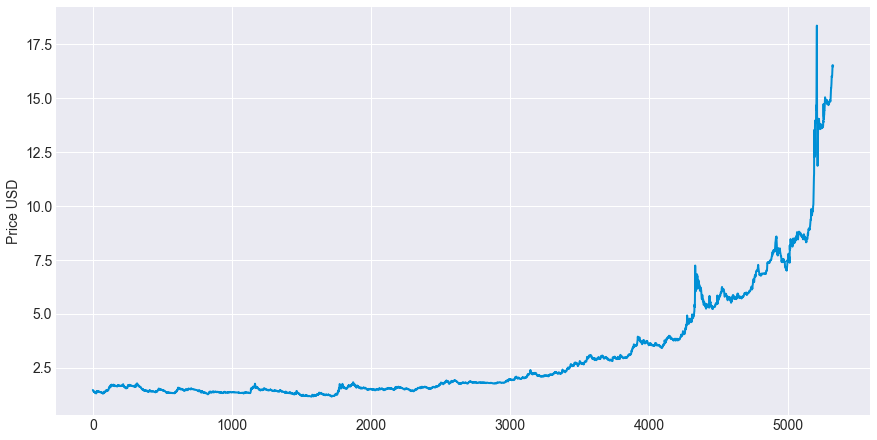

In [8]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(1, figsize=(13,7))
ax.plot(dataset, linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
plt.show()   ##high değerleri üzerinden grafik çizme.

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1)) ## 0 ile 1 aralığına normalize edildi.
dataset = scaler.fit_transform(dataset)

In [10]:
def dataset_generator_lstm(numpy_dataset, look_back):
    x, y = [], []

    look_back+=1
    for i in range(len(numpy_dataset) - look_back):
        window = numpy_dataset[i:i + look_back, 0]
        x.append(window[:-1]) #sonuncuyu katma (0-63)
        y.append(window[-1]) # sonuncu (64)

    return np.array(x), np.array(y)  #dataset pencelere bölünür.(64 günün sonundaki tahmin)

In [11]:
x, y = dataset_generator_lstm(dataset, look_back=96) ##pencereler
x

array([[0.0182416 , 0.01737019, 0.01585974, ..., 0.01414596, 0.01469785,
        0.01501737],
       [0.01737019, 0.01585974, 0.01580164, ..., 0.01469785, 0.01501737,
        0.01513356],
       [0.01585974, 0.01580164, 0.01490118, ..., 0.01501737, 0.01513356,
        0.01832874],
       ...,
       [0.73507268, 0.72692205, 0.73489839, ..., 0.87329058, 0.88628627,
        0.89322853],
       [0.72692205, 0.73489839, 0.73121522, ..., 0.88628627, 0.89322853,
        0.8896964 ],
       [0.73489839, 0.73121522, 0.73286509, ..., 0.89322853, 0.8896964 ,
        0.88959764]])

In [12]:
y ## 64. değer üzerinden yapmaya çalışılan doğru tahmin

array([0.01513356, 0.01832874, 0.01760257, ..., 0.8896964 , 0.88959764,
       0.89058524])

In [13]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))  ##LSTM fakrlı katmanlarda farklı data istiyor reshape x.shape[0]=64
y = np.reshape(y, (y.shape[0], 1))

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.2)

In [15]:
print(f"Eğitim Verilerinin Büyüklüğü: {x_train.shape}")
print(f"Test Verilerinin Büyüklüğü: {x_test.shape}")

Eğitim Verilerinin Büyüklüğü: (4182, 96, 1)
Test Verilerinin Büyüklüğü: (1046, 96, 1)


In [16]:
x_train #3reshape sonrası bakış

array([[[0.0182416 ],
        [0.01737019],
        [0.01585974],
        ...,
        [0.01414596],
        [0.01469785],
        [0.01501737]],

       [[0.01737019],
        [0.01585974],
        [0.01580164],
        ...,
        [0.01469785],
        [0.01501737],
        [0.01513356]],

       [[0.01585974],
        [0.01580164],
        [0.01490118],
        ...,
        [0.01501737],
        [0.01513356],
        [0.01832874]],

       ...,

       [[0.15425192],
        [0.15408926],
        [0.15282861],
        ...,
        [0.20019287],
        [0.20448023],
        [0.21902123]],

       [[0.15408926],
        [0.15282861],
        [0.15396726],
        ...,
        [0.20448023],
        [0.21902123],
        [0.21199763]],

       [[0.15282861],
        [0.15396726],
        [0.15579723],
        ...,
        [0.21902123],
        [0.21199763],
        [0.21198601]]])

In [17]:
y_train

array([[0.01513356],
       [0.01832874],
       [0.01760257],
       ...,
       [0.21199763],
       [0.21198601],
       [0.20724552]])

In [18]:
model = Sequential()
model.add(LSTM(units=x.shape[1], return_sequences=True, input_shape=(x.shape[1], x.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(units=x.shape[1], return_sequences=True, input_shape=(x.shape[1], x.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(units=x.shape[1], return_sequences=True, input_shape=(x.shape[1], x.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(units=x.shape[1], activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')


# model = Sequential()
# model.add(GRU(units=50, return_sequences=True, input_shape=(x.shape[1],1), activation='tanh'))
# model.add(Dropout(0.2))
# model.add(GRU(units=50, return_sequences=True, input_shape=(x.shape[1],1), activation='tanh'))
# model.add(Dropout(0.2))
# model.add(GRU(units=50, return_sequences=True, input_shape=(x.shape[1],1), activation='tanh'))
# model.add(Dropout(0.2))
# model.add(GRU(units=50, activation='tanh'))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.summary()
# model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96, 96)            37632     
_________________________________________________________________
dropout (Dropout)            (None, 96, 96)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96, 96)            74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 96, 96)            74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 96)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                7

In [19]:
loss = model.fit(x_train, y_train, epochs=20, batch_size=150, validation_data=(x_test, y_test)) #20 epoch üzerinden batch_size deneme yanılma,loss-train üzeirndeki performans , -val loss test üzerindeki. 4000/150=29

Epoch 1/20
28/28 [==============================] - 39s 1s/step - loss: 0.0013 - val_loss: 0.0038
Epoch 2/20
28/28 [==============================] - 35s 1s/step - loss: 5.7461e-05 - val_loss: 0.0036
Epoch 3/20
28/28 [==============================] - 28s 991ms/step - loss: 4.1368e-05 - val_loss: 0.0040
Epoch 4/20
28/28 [==============================] - 27s 964ms/step - loss: 3.7547e-05 - val_loss: 0.0024
Epoch 5/20
28/28 [==============================] - 25s 885ms/step - loss: 3.5957e-05 - val_loss: 0.0021
Epoch 6/20
28/28 [==============================] - 22s 787ms/step - loss: 3.2998e-05 - val_loss: 0.0017
Epoch 7/20
28/28 [==============================] - 19s 696ms/step - loss: 3.5207e-05 - val_loss: 0.0012
Epoch 8/20
28/28 [==============================] - 19s 679ms/step - loss: 2.9547e-05 - val_loss: 0.0023
Epoch 9/20
28/28 [==============================] - 19s 680ms/step - loss: 3.7221e-05 - val_loss: 0.0011
Epoch 10/20
28/28 [==============================] - 19s 670ms/st

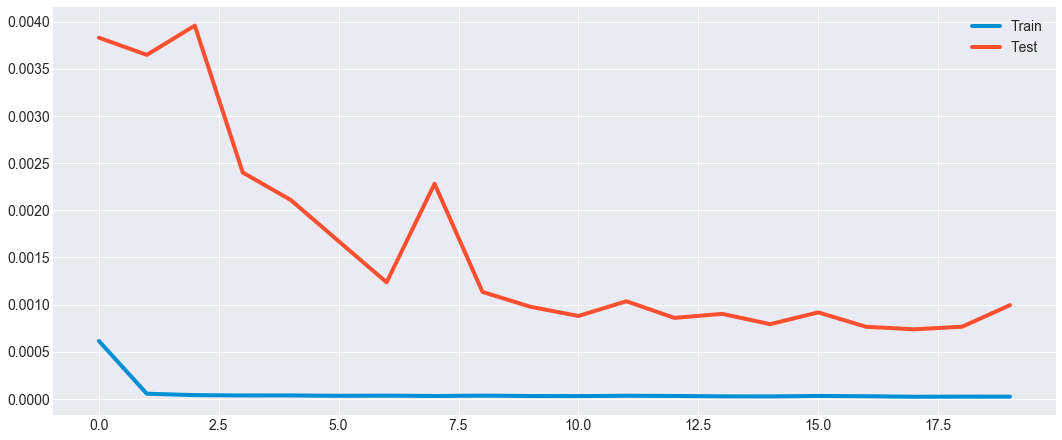

In [20]:
plt.figure(figsize=(16, 7))
plt.plot(loss.history['loss'], label='Train')
plt.plot(loss.history['val_loss'], label='Test')
plt.legend()
plt.show()  # train datası üzerinden mavide oldukça hızlı converge pointe gelindi. testteki performansı

In [21]:
y_pred = model.predict(x_test) #x_test üzerinde prediction
y_pred = scaler.inverse_transform(y_pred) #0-1 aralığında scale edilen değeri inverse transform edilerek değerler elde edilir

y_test = scaler.inverse_transform(y_test)

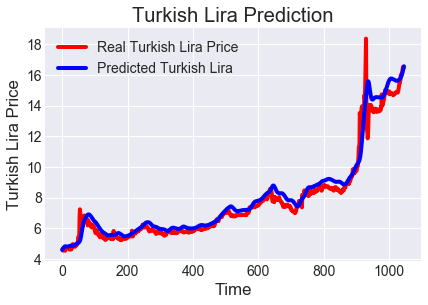

In [22]:
plot_predictions(y_test, y_pred)